### Import libraries

In [1]:
import pandas as pd
import numpy as np
import math
import re

### Loading data

In [2]:
DATA_FOLDER = 'data'
FOOD_FILE = 'food_data.csv'
COUNTRIES_FILE = 'countries_info.csv'
OVERWEIGHT_FILE = 'overweight.csv'
DIABETES_FILE = 'diabetes.csv'

In [3]:
all_datas = pd.read_csv(DATA_FOLDER + "/" + FOOD_FILE, sep='\t', low_memory=False)
countries_infos = pd.read_csv(DATA_FOLDER + "/" + COUNTRIES_FILE, sep=',', low_memory=False)
overweight = pd.read_csv(DATA_FOLDER + "/" + OVERWEIGHT_FILE, sep=',', low_memory=False)
diabetes = pd.read_csv(DATA_FOLDER + '/' + DIABETES_FILE, low_memory=False)

### Analysis of the different fields available in the dataset

We have to select only the features which is possible to help us to answer our questions

In [4]:
for col in all_datas.columns.values:
    print("- ", col)

-  code
-  url
-  creator
-  created_t
-  created_datetime
-  last_modified_t
-  last_modified_datetime
-  product_name
-  generic_name
-  quantity
-  packaging
-  packaging_tags
-  brands
-  brands_tags
-  categories
-  categories_tags
-  categories_en
-  origins
-  origins_tags
-  manufacturing_places
-  manufacturing_places_tags
-  labels
-  labels_tags
-  labels_en
-  emb_codes
-  emb_codes_tags
-  first_packaging_code_geo
-  cities
-  cities_tags
-  purchase_places
-  stores
-  countries
-  countries_tags
-  countries_en
-  ingredients_text
-  allergens
-  allergens_en
-  traces
-  traces_tags
-  traces_en
-  serving_size
-  serving_quantity
-  no_nutriments
-  additives_n
-  additives
-  additives_tags
-  additives_en
-  ingredients_from_palm_oil_n
-  ingredients_from_palm_oil
-  ingredients_from_palm_oil_tags
-  ingredients_that_may_be_from_palm_oil_n
-  ingredients_that_may_be_from_palm_oil
-  ingredients_that_may_be_from_palm_oil_tags
-  nutrition_grade_uk
-  nutrition_grade_f

We can deduce the usefull colums for our project:
 - product_name
 - sugars_100g
 - fat_100g
 - nutrition_grade_fr
 - countries
 - countries_tags


### Datasets clean
We clean our datasets. We select only the potential interesting fields. 

We do some operations on the countries tags to be able to parse the data. We also remove potential outliers.
In our case, some outliers may be having a larger sugar or fat content than 100g, since it defies the laws of physics :-p 

In [5]:
countries_infos = countries_infos[['COUNTRY_ALPHA2_CODE', 'COUNTRY_NAME']]

In [6]:
usefull_datas = all_datas.copy()
usefull_datas = usefull_datas[['product_name',
                   'countries',
                   'countries_tags',
                   'sugars_100g',
                   'fat_100g']]

usefull_datas['countries_tags'].replace(regex=True, inplace=True, to_replace=r'\w\w:', value=r'')
usefull_datas = usefull_datas[usefull_datas['sugars_100g'] <= 100]
usefull_datas = usefull_datas[usefull_datas['fat_100g'] <= 100]
        
#get a feel of the data
usefull_datas

,product_name,countries,countries_tags,sugars_100g,fat_100g
0,Vitória crackers,en:france,france,15.00,7.00
2,Sauce Sweety chili 0%,en:france,france,0.40,0.00
4,Salade de carottes râpées,en:france,france,3.90,0.30
5,Fromage blanc aux myrtilles,en:france,france,16.30,4.90
8,Baguette parisien,en:france,france,1.80,3.30
9,&quot;Baguette Lyonnais&quot;,en:france,france,2.00,9.40
10,Solène céréales poulet,France,france,1.70,5.90
11,Tarte noix de coco,en:france,france,21.90,22.00
12,Salade de fruits exotiques,en:france,france,23.00,0.00
13,Chouquettes x 30,en:france,france,20.00,21.00


We contruct a datastructure with the countries codes map to their names (in different languages), in order to group all the different ways the countries were written together

In [7]:
countries = []

for c in usefull_datas['countries_tags'].dropna():
    #split list of countries on the comma
    for country in c.split(','):
        country = country.strip().lower()
        found = re.search('\w\w:(.+)', country, re.IGNORECASE)  
        if found:
            country = found.group(1)
        if country not in countries:
            countries.append(country)

countries_with_code = []
#apply lower case to country names
countries_infos['COUNTRY_NAME'] = countries_infos['COUNTRY_NAME'].apply(lambda x: str(x).lower())

for c in countries:
    is_present = False
    #loop over rows having matching country names with countries data
    for index, c_i in countries_infos[countries_infos['COUNTRY_NAME'] == c.lower()].iterrows():
        #add tuple containing country name and country code
        countries_with_code.append((c, c_i['COUNTRY_ALPHA2_CODE']))
        is_present = True
        break
    if not is_present:
        countries_with_code.append((c, "???"))

We select only the countries for which we have information. (They are contained in the open food database)

In [8]:
count = 0
proper_countries = []
for c in countries_with_code:
    if c[1] != "???":
        proper_countries.append(c)
        

display(proper_countries)

[('france', 'FR'),
 ('canada', 'CA'),
 ('oman', 'OM'),
 ('germany', 'DE'),
 ('belgium', 'BE'),
 ('netherlands', 'NL'),
 ('mexico', 'MX'),
 ('australia', 'AU'),
 ('switzerland', 'CH'),
 ('egypt', 'EG'),
 ('italy', 'IT'),
 ('spain', 'ES'),
 ('saudi-arabia', 'SA'),
 ('iraq', 'IQ'),
 ('sverige', 'SE'),
 ('sweden', 'SE'),
 ('vietnam', 'VN'),
 ('singapore', 'SG'),
 ('thailand', 'TH'),
 ('greece', 'GR'),
 ('panama', 'PA'),
 ('malaysia', 'MY'),
 ('luxembourg', 'LU'),
 ('lebanon', 'LB'),
 ('denmark', 'DK'),
 ('guyana', 'GY'),
 ('serbia', 'RS'),
 ('martinique', 'MQ'),
 ('barbados', 'BB'),
 ('ireland', 'IE'),
 ('aruba', 'AW'),
 ('bahrain', 'BH'),
 ('taiwan', 'TW'),
 ('cuba', 'CU'),
 ('portugal', 'PT'),
 ('kuwait', 'KW'),
 ('austria', 'AT'),
 ('japan', 'JP'),
 ('israel', 'IL'),
 ('royaume-uni', 'GB'),
 ('brazil', 'BR'),
 ('morocco', 'MA'),
 ('guinea', 'GN'),
 ('china', 'CN'),
 ('algeria', 'DZ'),
 ('mauritius', 'MU'),
 ('indonesia', 'ID'),
 ('turkey', 'TR'),
 ('belgien', 'BE'),
 ('deutschland', 'DE

When a rows mention many countries we explode the dataframe to get one line for each country.

In [9]:
def get_tag(country_name):
    for c in proper_countries:
        if c[0] == country_name:
            return c[1]
        
    return "TBD"

rows = []

#Explode inital df
for index, data in usefull_datas.iterrows():
    countries = str(data['countries_tags']).split(',')
    
    for c in countries:
        data['countries_tags'] = get_tag(c.strip().lower())
        rows.append(data)
        

parsed_datas = pd.DataFrame(rows)

### Get results
Now we compute result from the parsed datasets. We would like to get the mean average of sugar and fat per 100g per country.

In [10]:
grouped = parsed_datas.groupby(['countries_tags'])
means = grouped.mean()
means

,sugars_100g,fat_100g
countries_tags,,
AD,1.708000,6.512000
AL,8.925000,3.900000
AR,25.568333,17.087222
AT,8.527550,14.451258
AU,12.672323,10.883420
AW,8.000000,17.300000
AZ,0.000000,0.200000
BE,12.409372,14.409027
BG,30.115000,20.775000


In [11]:
grouped = parsed_datas.groupby(['countries_tags'])
counted = grouped.count()

In [12]:
sugar = means[['sugars_100g']].dropna()
#remove outliers
sugar = sugar[sugar['sugars_100g'] <= 100]
#we would like to have countries with a big enough sample of values in the database, we choose 20 for now
sugar = sugar[counted['sugars_100g'] > 20]
#sort values
sugar.sort_values(by=['sugars_100g'], ascending=False, inplace=True)
sugar.plot.bar(figsize=(15,10))

We can see which countries consume the most sugars according to our datas.

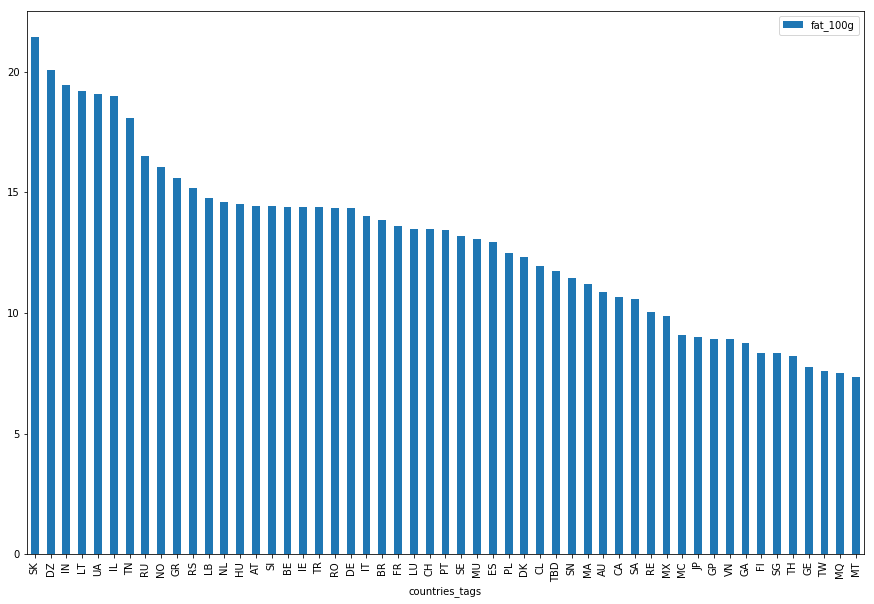

In [13]:
#remove null values
fat = means[['fat_100g']].dropna()
#remove outliers
fat = fat[fat['fat_100g'] <= 100]
#remove values with small sample
fat = fat[counted['fat_100g'] > 20]
#sort
fat.sort_values(by=['fat_100g'], ascending=False, inplace=True)
fat.plot.bar(figsize=(15,10))

We can see which countries consume the most fat according to our datas. 
We can guess some correlations, for instance (Slovakia are on the top of the ranking for each aspect) and some independant values (Germany use a lot of fat but not so much sugar), but we would need to calculate to be sure (next milestone)

We get the union of the sugar and fat datas to filter some other results.

In [14]:
indexes = pd.DataFrame(np.concatenate((sugar.index.values,fat.index.values)))
indexes = indexes.drop_duplicates()

In [15]:
overweight_datas = overweight.copy()
#choose data for a specific year. Unfortunately our dataset only goes up until 2016, so we choose that year.
overweight_datas = overweight_datas[overweight_datas['Year'] == 2016]
#get country codes
overweight_datas['Entity'] = overweight_datas['Entity'].apply(lambda x: get_tag(str(x).lower().strip()))
#remove rows with no country code
overweight_datas = overweight_datas[overweight_datas['Entity'] != 'TBD']
#set index so it's easier to plot
overweight_datas = overweight_datas.set_index(['Entity'])
#keep relevant column
overweight_datas = overweight_datas[['Indicator']]
#sort values
overweight_datas = overweight_datas.sort_values(by=['Indicator'], ascending=False)
overweight_datas = overweight_datas[overweight_datas.index.isin(indexes[0])]

overweight_datas

,Indicator
Entity,
TR,32.1
LB,32.0
CA,29.4
AU,29.0
MX,28.9
MT,28.9
CL,28.0
DZ,27.4
TN,26.9


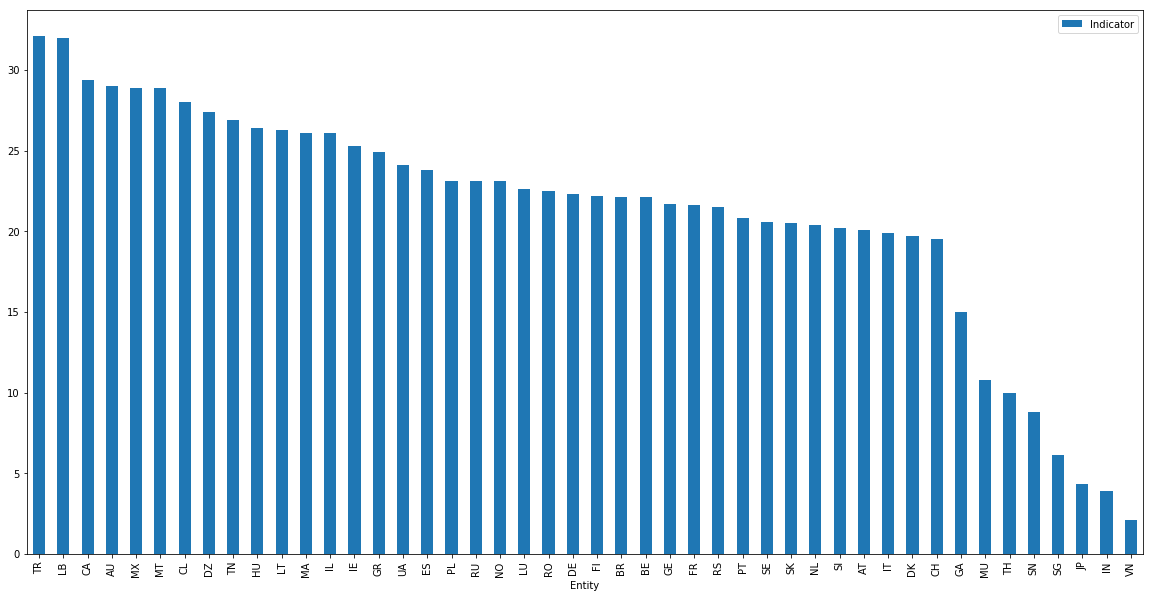

In [16]:
overweight_datas.plot.bar(figsize=(20,10))

As we can see : It is difficult to guess a correlation between the previous obsrvations (sugar & fat) and the obesity percentage displayed above. 
For example the slovakia is in the mean (for the obesity) but not really for the sugar & fat. That is only a guess we have to provide a scatter plot to proove it.

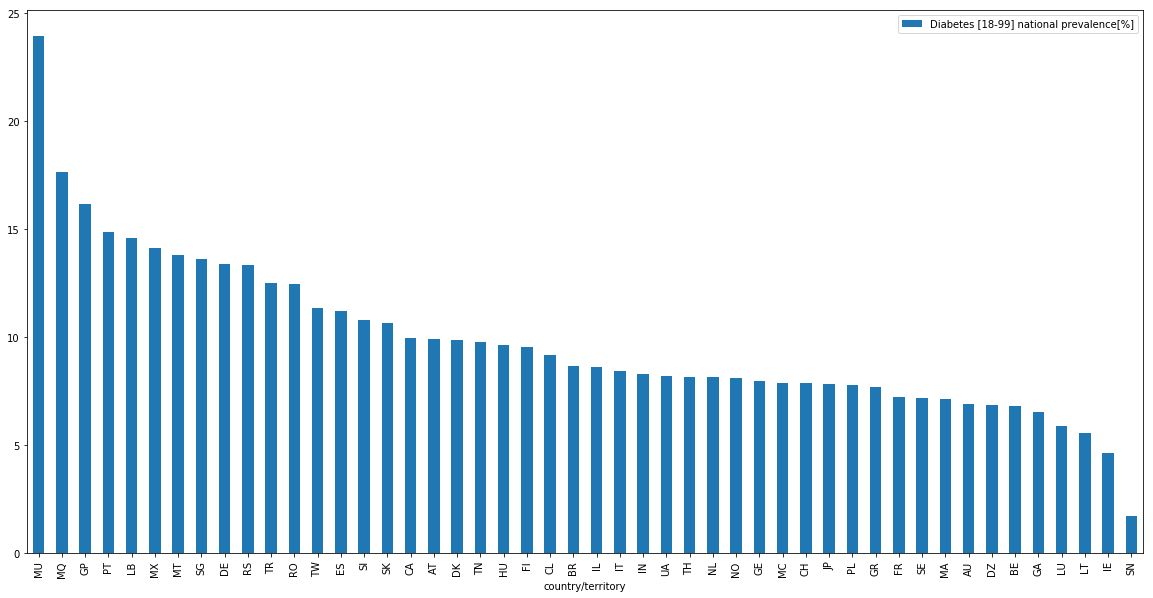

In [18]:
#drop some useless columns
to_drop=['prev', 'Unnamed: 5']
diab = diabetes.drop(to_drop, axis=1)
#select relevant columns
diab=diab[['country/territory', 'Diabetes [18-99] national prevalence[%]']]
#convert string column to numeric, in order to plot it, remove % at the end
diab['Diabetes [18-99] national prevalence[%]'] = pd.to_numeric(diab['Diabetes [18-99] national prevalence[%]'].str[:-1])
#get country codes
diab['country/territory'] = diab['country/territory'].apply(lambda x: get_tag(str(x).lower().strip()))
#remove rows without country codes
diab = diab[diab['country/territory'] != 'TBD']
#set index for more agreable plotting
diab.set_index('country/territory', inplace=True)
diab = diab[diab.index.isin(indexes[0])]
#sort values
diab= diab.sort_values(by=['Diabetes [18-99] national prevalence[%]'],ascending=False)
diab.plot.bar(figsize=(20,10))

Like for the obesity : it is difficult to guess a correlation between the previous obsrvations (sugar & fat) and the diabetes percentage display above. Same example : slovakia is in just after the middle but not really for the sugar & fat. Once more that is only a guess we have to provide a scatter plot to proove it.

### Summarize
We selected the datas who have an interest for us. We parse them to be able to get some results from it. We already get some results concerning alimentation quality of different countries. The really next step is to prove if a correlation exists between our results. (We have some guesses, but we have to provide a scatter plot and a correlation coefficient to proove it)

### What comes next

First, we reoriented our approach of our study. 
We decided to globalize our approach and not to focus our work only on the european countries. 
Indeed not too many countries have relevant data so we can include all of them.

We spent a lot of time on cleaning the datasets, so we focused our milestone on the countries part. 
We now will be able to have more relevant results, such as a visualization of the correlation (or not) between features.
We will focus on the food quality in the next steps, such as finding which particular foods have a higher sugar or fat content, instead of just comparing the countries. 

#### Research questions 
As we discussed above we did not yet work on the food quality, so we are not able to answer our research questions for the moment. We have to extract more data and try to find a correlation with the ones we already have. 